In [218]:
import dotenv
from IPython.display import display, Image
from langgraph.types import interrupt, Command
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, AIMessage
from typing import List, Optional
from langgraph.prebuilt import ToolNode, tools_condition
from pydantic import Field
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.output_parsers import StrOutputParser


dotenv.load_dotenv()

True

### RAG

##### Documents

In [219]:
from pathlib import Path

sheets_path = Path("data/karty-postaci/")
sheets = sheets_path.glob("*.md")

sheets_raw = []
for sheet in sheets:
    with open(sheet, "r") as f:
        sheets_raw.append(f.read())

sheets_raw

['# TWORZENIE TEKKNIKA\n\nAby stworzyć swojego tekknika, wybierz imię, wygląd, cechy, ruchy, warsztat oraz projekty.\n\n## OPIS POSTACI\n\nJest jedna rzecz, na którą zawsze można liczyć w Świecie Apokalipsy: wszystko się psuje.\n\n## IMIĘ\n\n- Leah\n- Joshua\n- Tai\n- Ethan\n- Bran\n- Jeremy\n- Amanuel\n- Justin\n- Jessica\n- Eliza\n- Dylan\n- Adnan\n- Alan\n- Nils\n- Ellen\n- Lee\n- Kim\n- Adele\n- Leone\n- Burdick\n- Oliver\n- Goldman\n- Whiting\n- Fauci\n- Hoss\ue014eld\n- Lemma\n- Morrell\n- Ozair\n- Robinson\n- Lemieux\n- Whitmont\n- Cullen\n- Spector\n\n## WYGLĄD\n\n- Płeć: Mężczyzna, kobieta, dwuznaczny lub transgresywny.\n- Ubiór: roboczy technika, zniszczony technika, staroświecki technika, codzienny technika.\n- Twarz: pospolita, ładna, szczera, żywa.\n- Oczy: zmrużone, spokojne, śmiejące się, rozbiegane, taksujące.\n- Ciało: grube, drobne, zgarbione, żylaste, krępe, dziwaczne.\n\n## CECHY\n\nWybierz jeden zestaw cech:\n\n- Spokój−1 Hart=0 Urok+1 Spryt+1 Dziw+2\n- Spokój=0 Ha

##### Splits

In [248]:
from langchain_text_splitters import MarkdownHeaderTextSplitter

headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
]

markdown_splitter = MarkdownHeaderTextSplitter(headers_to_split_on, strip_headers=False)

md_header_splits = []
for sheet in sheets_raw:
    md_header_splits.append(markdown_splitter.split_text(sheet))

md_header_splits

md_header_splits[0][0]

Document(metadata={'Header 1': 'TWORZENIE TEKKNIKA'}, page_content='# TWORZENIE TEKKNIKA  \nAby stworzyć swojego tekknika, wybierz imię, wygląd, cechy, ruchy, warsztat oraz projekty.')

##### Chroma DB

In [ ]:
from langchain_community.vectorstores import Chroma
from langchain_openai.embeddings import OpenAIEmbeddings

db = Chroma(persist_directory="db/", embedding_function=OpenAIEmbeddings())

for sheet in md_header_splits:
    db.add_documents(sheet)

db

##### Retriever

In [291]:
from langchain.tools.retriever import create_retriever_tool

main_retriever = db.as_retriever(search_kwargs={'k': 4}, search_type="similarity")

retriever_tool = create_retriever_tool(
    main_retriever,
    "retrieve_character_sheet",
    "Search and return information about how to create characters for tabletop RPG game 'Świat Apokalipsy'.",
)

description_retriever = db.as_retriever(search_kwargs={'k': 1, "filter":{"Header 2": "OPIS POSTACI"}}, search_type="similarity")

description_retriever_tool = create_retriever_tool(
    description_retriever,
    "describe_character_sheet",
    "Search and return information about characters description (OPIS _class_name_) for tabletop RPG game 'Świat Apokalipsy'.",
)

retriever_tool

Tool(name='retrieve_character_sheet', description="Search and return information about how to create characters for tabletop RPG game 'Świat Apokalipsy'.", args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x7f1b17d6ac00>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f1b053965d0>, search_kwargs={'k': 4}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n'), coroutine=functools.partial(<function _aget_relevant_documents at 0x7f1b15341bc0>, retriever=VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x7f1b053965d0>, search_kwargs={'k': 4}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variabl

## Model, tools, graph state

In [292]:
class Answer(TypedDict):
    """Answer to a question"""

    answer: Annotated[str, ..., "The answer to the question"]


class Question(TypedDict):
    """Question to ask the user"""

    question: Annotated[str, ..., "The question to ask the user"]
    guidance: Annotated[str, ..., "Guidance to help the user answer the question"]
    answer: Annotated[Optional[str], ...]


class Questions(TypedDict):
    """List of questions to ask the user"""

    questions: List[Question] = Field(description="The questions to ask the user", min_length=3)

class CharactersSummary(TypedDict):
    """Summary of the characters in the story"""

    appearance: Annotated[str, ..., "Description of the character's appearance"]
    description: Annotated[str, ..., "Description of the character"]


# State - has messages from MessagesState
class GraphState(MessagesState):
    questions: Questions
    summary: CharactersSummary
    character_class: Optional[Annotated[str, ..., "The class of the character"]]


model = ChatOpenAI(model="gpt-4o-mini")
model_with_json_questions_output = model.with_structured_output(Questions)
model_with_json_summary_output = model.with_structured_output(CharactersSummary)

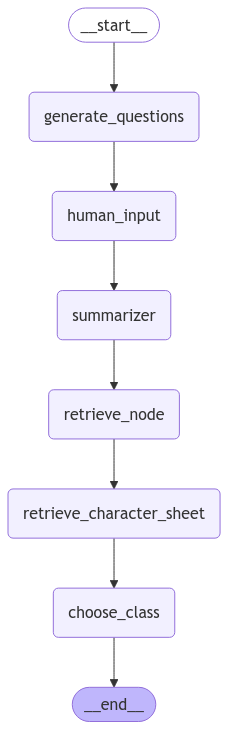

In [300]:
from typing import Literal
from langchain_core.prompts import PromptTemplate
from pydantic import BaseModel


# Node
def generate_questions(state: GraphState):
    sys_msg = SystemMessage("""
You are helpful assistant to generate 3 helpful questions with a short guidance about how to answer them based on given information.
Those questions should be helpful to later generate a character for the tabletop RPG game called "Świat Apokalipsy".
Question should be more specific than general and should help to fill character's sheet like class, skills, items.

You will receive a 4 block of information:
1. basic information which will contain name of the character, age and other basic information.
    example: Moja postać ma na imię Max, ma 25 lat, jest wysokim, szczupłym mężczyzną o ciemnych włosach i niebieskich oczach.
2. history of the character which will contain information about the past and skills of the character gained during the past.
    example: Max urodził się w małej wiosce, gdzie jego rodzina prowadziła gospodarstwo rolne. W wieku 18 lat opuścił rodzinny dom i wyruszył w świat, aby zdobyć nowe doświadczenia. Podczas swoich podróży nauczył się walczyć i przetrwać w trudnych warunkach.
3. Character's traits which will contain information about the character's personality and other traits.
    example: Max jest odważny, lecz nieufny wobec obcych. Jest lojalny wobec swoich przyjaciół i gotów poświęcić się dla nich. Często działa impulsywnie, co prowadzi go do niebezpiecznych sytuacji.
4. Game's world information which will contain information about the world where the game takes place.
    example: Świat postapokaliptycznego przedmieścia Warszawy, gdzie przetrwali unikają stolicy.

Example of questions:
1. Co sprawiło, że Twoja postać przetrwała apokalipsę?
    Pomyśl o umiejętnościach, szczęściu lub okolicznościach, które pozwoliłyby Twojej postaci przetrwać.
2. Jakie wydarzenie z przeszłości Twojej postaci miało największy wpływ na jej obecną postawę?
    Może to być trauma, triumf lub inna sytuacja, która ukształtowała Twoją postać.
3. Kogo Twoja postać straciła podczas apokalipsy i jak to wpłynęło na jej życie?
    Zastanów się nad relacjami i więzami, które zostały zerwane.

Your output should be in Polish language and contain exactly 3 questions.
""")

    questions = model_with_json_questions_output.invoke([sys_msg] + state["messages"])
    return {"messages": [], "questions": questions}


# Node
def human_input(state: GraphState):
    human_message = interrupt("human_input")
    for i, answer in enumerate(human_message["answers"]):
        answer_t = answer["answer"]
        print(state["questions"]["questions"])
        state["questions"]["questions"][i]["answer"] = answer_t

    print(state["questions"])

    return {"messages": [], "questions": state["questions"]}


# Node
def summarizer(state: GraphState):
    sys_msg = SystemMessage(
        """You are helpful assistant to generate a summary of the character based on the given information.

        Your task is to generate a summary of the character based on the information provided by the user in the same language as the input.

        Your output should contain the following information:

        Wygląd (appearance) - basic information about the character's appearance, short but detailed description. 1-2 sentences.
        Opis (description) -  description of the character. May contain extremely short background and basic traits. 5 sentences at most.
        """
    )

    last_human_message = state["messages"][0]

    answers = ""
    for question in state["questions"]["questions"]:
        answers += f"{question['answer']}\n"

    character_info = last_human_message.content + "\n" + answers

    summary = model_with_json_summary_output.invoke([sys_msg] + [character_info])

    text_summary = f"{summary["appearance"]}\n{summary["description"]}"
    ai_message = AIMessage(text_summary)
    state["messages"].append(ai_message)
    return {"messages": state["messages"], "summary": summary}


# Node
def retrieve_node(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]
    
    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = PromptTemplate(
        template="""
        You are an assistant for retrieving information about the character's description for tabletop RPG game 'Świat Apokalipsy'.
        Use the following pieces of information to retrieve the character's class description.
        information about the character to which the description should be related: \n\n {context} \n\n
        """,
        input_variables=["context"],
    )

    model_with_tools = model.bind_tools([description_retriever_tool])
    chain = prompt | model_with_tools

    response = chain.invoke([last_message])

    docs = description_retriever.get_relevant_documents(last_message.content)
    print(f"{docs=}")
    return {"messages": [response]}

# Edge
# def grade_document(state: GraphState) -> Literal["choose_class", "retrieve_character_sheet"]:
#     """
#     Determines whether the retrieved documents are relevant to the question.
#     """

#     # Data model
#     class grade(BaseModel):
#         """Binary score for relevance of the document"""

#         binary_score: str = Field(description="Binary score for relevance of the document")

#     grade_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
#     llm_with_tools = grade_model.with_structured_output(grade)

#     prompt = PromptTemplate(
#         template="""
#         You are a grader assessing relevance of a retrieved document related to the character summary.
#         Here is the retrieved document: \n\n {context} \n\n
#         You need to access best suited character for the given summary: \n\n {summary} \n\n
#         If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.\n
#         Give a binary score 'yes' or 'no' score to indicate whether the character description is related to the summary.
#         """,
#         input_variables=["context", "summary"],
#     )

#     # Chain
#     chain = prompt | llm_with_tools

#     summary = state["summary"]["appearance"] + state["summary"]["description"]
#     docs = state["messages"][-1].content
#     scored_result = chain.invoke({"summary": summary, "context": docs})

#     score = scored_result.binary_score

#     if score == "yes":
#         return "choose_class"
#     else:
#         return "retrieve_character_sheet"



# Node
def choose_class(state: GraphState):
    messages = state["messages"]
    last_message = messages[-1]

    docs = last_message.content

    prompt = PromptTemplate(
        template="""
        You are an assistant for choosing character's class for "Świat Apokalipsy" tabletop RPG tasks.
        Use the following pieces of retrieved context to determine the best class for the character.

        Possible classes:
        1. Anioł
        2. Chopper
        3. Egzekutor
        4. Gubernator
        5. Guru
        6. Kierowca
        7. Muza
        8. Operator
        9. Psychol
        10. Tekknik
        11. Żyleta

        Retrieved documents: \n\n {context} \n\n
        Answer with the class name.
        """,
        input_variables=["context"],
    )

    model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    chain = prompt | model | StrOutputParser()

    response = chain.invoke({"context": docs})
    print(f"Class is {response}")
    return {"character_class": response}


workflow = StateGraph(GraphState)

workflow.add_node("generate_questions", generate_questions)
workflow.add_node("human_input", human_input)
workflow.add_node("summarizer", summarizer)
workflow.add_node("retrieve_node", retrieve_node)
description_retrieve_character_sheet = ToolNode([description_retriever_tool])
workflow.add_node("retrieve_character_sheet", description_retrieve_character_sheet)
workflow.add_node("choose_class", choose_class)


workflow.add_edge(START, "generate_questions")
workflow.add_edge("generate_questions", "human_input")
workflow.add_edge("human_input", "summarizer")
workflow.add_edge("summarizer", "retrieve_node")
workflow.add_edge("retrieve_node", "retrieve_character_sheet")
workflow.add_edge("retrieve_character_sheet", "choose_class")


workflow.add_edge("choose_class", END)

checkpointer = MemorySaver()

graph = workflow.compile(checkpointer=checkpointer)

display(Image(graph.get_graph().draw_mermaid_png()))

In [301]:
config = {"configurable": {"thread_id": "2"}}

joseph_mechanik = {
    "messages": "Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez oka i długimi włosami, nosi opaskę.\n\nZa życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.\n\nJoseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.\n\nOstatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie."
}

ania_lekraz = {
    "messages": "Ania jest 25 letnią kobietą o krótkich blond włosach i zielonych oczach, nosi okulary.\n\nZa życia była lekarką i prowadziła małą przychodnię w Otwocku.\n\nAnia jest bardzo cicha i skryta, ale zawsze gotowa pomóc innym.\n\nOstatnia wojna"
}

resp = graph.invoke(
    joseph_mechanik,
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

print()
print(resp["questions"])

# print()
# print(resp["answers"])

# print(type(resp["questions"]))

# print()
# print(resp["questions"]["questions"][0]["question"])

================================ Human Message =================================

Joseph jest 35 letnim mężczyzną o szerokiej sylwetce bez oka i długimi włosami, nosi opaskę.

Za życia był udanym mechanikiem i prowadził dużą sieć serwisów samochodowych.

Joseph jest bardzo szczerym i wesołym, zawsze znajdzie moment na żart.

Ostatnia wojna nuklearna zmasakrowała cały świat, ale cudem ominęła Otwock, który leży przy Warszawie.

{'questions': [{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanika może pomóc w naprawie pojazdów lub konstrukcji w trudnych warunkach.', 'answer': ''}, {'question': 'Jakie relacje Joseph nawiązał w nowym świecie po apokalipsie?', 'guidance': 'Rozważ, czy Joseph ma przyjaciół, sojuszników lub wrogów, i jak te relacje wpływają na jego codzienne życie.', 'answer': ''}, {'question': 'Jak Joseph radzi sobie z utratą oka i jak to wpływa na jego osobowość?', '

In [302]:
joseph_answers = {
    "answers": [
        {"answer": "Joseph przetrwał dzięki swoim umiejętnościom naprawy czegokolwiek, co tylko może się zepsuć."},
        {"answer": "Czysto biznesowe."},
        {"answer": "Młotek, taśma i klej. Najważniejsze rzeczy do naprawy."},
    ],
}

ania_anwers = {
    "answers": [
        {"answer": "Ania wykorzystuje swoje umiejętności chirurgiczne by pomagać znajomym."},
        {"answer": "Ania jest zimna i szybka w swoich decyzjach, które często ratują życia i losy."},
        {"answer": "Wygoda i zabezpieczenie siebie."},
    ],
}

resp = graph.invoke(
    Command(resume=joseph_answers),
    config=config,
)

for m in resp["messages"]:
    m.pretty_print()

print()

print(resp["questions"])

[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanika może pomóc w naprawie pojazdów lub konstrukcji w trudnych warunkach.', 'answer': ''}, {'question': 'Jakie relacje Joseph nawiązał w nowym świecie po apokalipsie?', 'guidance': 'Rozważ, czy Joseph ma przyjaciół, sojuszników lub wrogów, i jak te relacje wpływają na jego codzienne życie.', 'answer': ''}, {'question': 'Jak Joseph radzi sobie z utratą oka i jak to wpływa na jego osobowość?', 'guidance': 'Zastanów się, czy brak oka wpłynął na jego poczucie humoru lub na to, jak postrzega siebie i innych w nowym świecie.', 'answer': ''}]
[{'question': 'Jakie umiejętności mechaniczne Joseph wykorzystuje w postapokaliptycznym świecie?', 'guidance': 'Pomyśl o tym, jak jego doświadczenie jako mechanika może pomóc w naprawie pojazdów lub konstrukcji w trudnych warunkach.', 'answer': 'Joseph przetrwał dzięki swoim umiejętnościom naprawy 

In [303]:
print(resp["summary"])

{'appearance': 'Joseph jest 35-letnim mężczyzną o szerokiej sylwetce, bez jednego oka i długich włosach, które nosi pod opaską.', 'description': 'Za życia Joseph był udanym mechanikiem, prowadzącym dużą sieć serwisów samochodowych. Jest bardzo szczerym i wesołym człowiekiem, który zawsze potrafi rozbawić innych. Ostatnia wojna nuklearna zniszczyła większość świata, ale Otwock, w którym mieszka, cudem uniknął zagłady. Joseph przetrwał dzięki swoim umiejętnościom naprawy wszelkich przedmiotów. Jego podstawowe narzędzia to młotek, taśma i klej, które uważa za najważniejsze do wykonywania napraw.'}


In [304]:
description_retriever.invoke(resp["summary"]["description"])[0].metadata["Header 1"].split(" ")[-1]

'EGZEKUTORA'

In [305]:
resp["character_class"]

'Egzekutor'